In [1]:
# load necessary libraries. install what you don't have
import numpy as np
import pandas as pd
import requests
import requests
import urllib
import os
import pprint
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
import sklearn 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
df = pd.read_excel("../DATA/original_data.xls", sheet_name="Data")

In [3]:
#Columns from original dataset we want to keep
columns_to_keep = ["Date", "S&P Comp. P", "Earnings", "Real Total Return Price" ]
df = df[columns_to_keep]

#Date format is inconsistent so lets make the formatting better and recognized as a date data type
df["Date"] = pd.to_datetime(df["Date"].astype(str), format="%Y-%m-%d")

#Filter out all dates before 1965, reconsider if this is a good selection later
df = df[df["Date"] >= "1965-01-01"]

df = df.sort_values("Date").reset_index(drop=True)

#Added PE ratio column
df["PE Ratio"] = df["S&P Comp. P"] / df["Earnings"]

#Drop price and earnings columns because that data is now stored in the PE column
df = df.drop(columns=["S&P Comp. P", "Earnings"])

#df.rename(columns={"10 Year Annualized Stock Real Return": "10 Year Return"}, inplace=True)


print(df.head())

        Date  Real Total Return Price   PE Ratio
0 1965-01-01            109618.976259  18.748925
1 1965-01-01            117075.340722   18.09703
2 1965-02-01            110689.595261  18.709548
3 1965-03-01            110707.980510  18.553419
4 1965-04-01            112076.467028  18.585224


In [4]:
# General function to calculate N-year returns
#Takes in 3 paramaters, a date, the dataframe, and then how many years out you want to calculate annual returns for
def get_n_year_return(date, df, years):
    #Calculates a target date by adding desired amount of years to current date to get futrue date (defaults to 10)
    target_date = date + pd.DateOffset(years=years)
    #Filters dataframe to only include dates that occur after the date provided to make searching quicker, then looks for the target date n years out
    
    # Filter the DataFrame to only include dates on or after the target date
    future_rows = df[df["Date"] >= target_date]

    # Check if there are any rows left after filtering
    if not future_rows.empty:
        # Select the first row (earliest available future date)
        future_row = future_rows.iloc[0]
    else:
        # If no future row is found, return None
        future_row = None


    if future_row is not None:
        #If some observation n years out exists, then using the compound annual growth formula given by original dataset calcualte the CAGR annual return 
        return (future_row["Real Total Return Price"] / df[df["Date"] == date]["Real Total Return Price"].values[0]) ** (1/years) - 1
    return None  # Return None if no valid future date is found

# Create an empty list to store results
five_year_returns = []
three_year_returns = []


# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    five_year_returns.append(get_n_year_return(row["Date"], df, 5))
    three_year_returns.append(get_n_year_return(row["Date"], df, 3))

# Assign results to new columns
df["5 Year Annual Return"] = five_year_returns
df["3 Year Annual Return"] = three_year_returns

# Display the first few rows
print(df.head())


        Date  Real Total Return Price   PE Ratio  5 Year Annual Return  \
0 1965-01-01            109618.976259  18.748925             -0.013341   
1 1965-01-01            117075.340722   18.09703             -0.013341   
2 1965-02-01            110689.595261  18.709548             -0.006861   
3 1965-03-01            110707.980510  18.553419             -0.003975   
4 1965-04-01            112076.467028  18.585224             -0.013485   

   3 Year Annual Return  
0              0.062185  
1              0.062185  
2              0.016211  
3              0.009866  
4              0.029799  


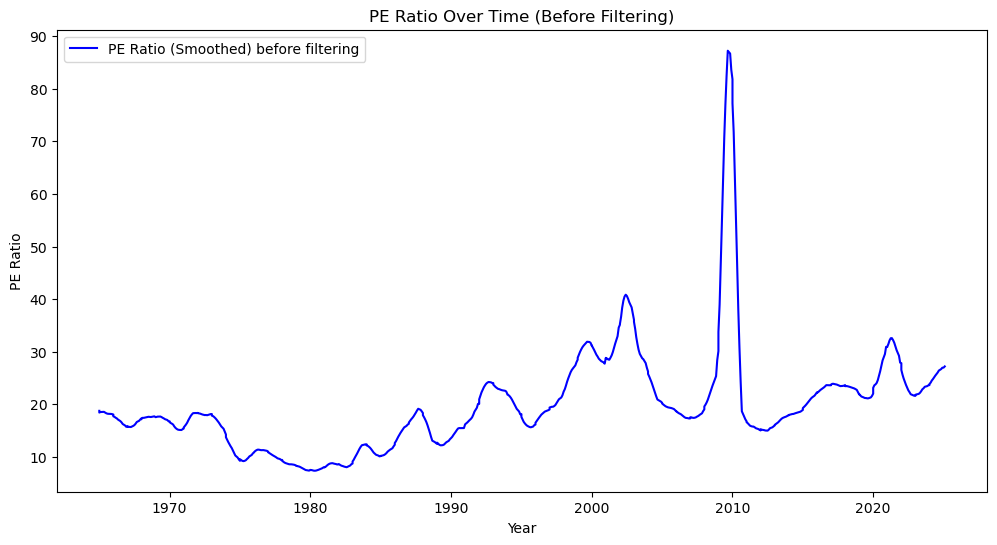

In [5]:
# Plot PE Ratio over time before filtering
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["PE Ratio"].rolling(window=12, min_periods=1).mean(), 
         label="PE Ratio (Smoothed) before filtering", color='blue')
plt.xlabel("Year")
plt.ylabel("PE Ratio")
plt.title("PE Ratio Over Time (Before Filtering)")
plt.legend()
plt.show()


In [6]:
# Compute the 5th and 95th percentiles
low_cutoff = df["PE Ratio"].quantile(0.05)
high_cutoff = df["PE Ratio"].quantile(0.95)

# Filter out outliers
df_filtered = df[(df["PE Ratio"] >= low_cutoff) & (df["PE Ratio"] <= high_cutoff)]


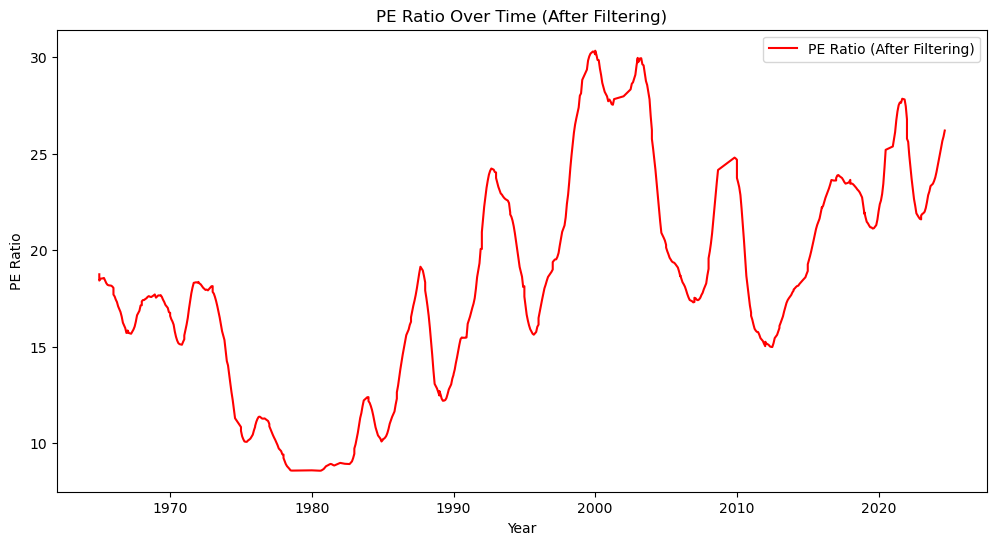

In [7]:
# Plot PE Ratio over time after filtering
plt.figure(figsize=(12,6))
plt.plot(df_filtered["Date"], df_filtered["PE Ratio"].rolling(window=12, min_periods=1).mean(), label="PE Ratio (After Filtering)", color='red')
plt.xlabel("Year")
plt.ylabel("PE Ratio")
plt.title("PE Ratio Over Time (After Filtering)")
plt.legend()
plt.show()


In [8]:
from statsmodels.tsa.stattools import adfuller

# Dickey Fuller test for Stationary Data

# Perform the ADF test on PE Ratio
adf_pe = adfuller(df_filtered["PE Ratio"].dropna())  
print("ADF Statistic for PE Ratio:", adf_pe[0])
print("p-value for PE Ratio:", adf_pe[1])

# Perform the ADF test on 3-Year Return
adf_3y = adfuller(df_filtered["3 Year Annual Return"].dropna())
print("ADF Statistic for 3 Year Return:", adf_3y[0])
print("p-value for 3 Year Return:", adf_3y[1])

# Perform the ADF test on 5-Year Return
adf_5y = adfuller(df_filtered["5 Year Annual Return"].dropna())
print("ADF Statistic for 5 Year Return:", adf_5y[0])
print("p-value for 5 Year Return:", adf_5y[1])


ADF Statistic for PE Ratio: -2.159774817053659
p-value for PE Ratio: 0.22116730362846043
ADF Statistic for 3 Year Return: -2.8394056296737795
p-value for 3 Year Return: 0.05286167843211653
ADF Statistic for 5 Year Return: -2.2754190951491045
p-value for 5 Year Return: 0.18001838492863304


In [9]:
#IF P value is <0.05 we can reject the null hypothesis which means are data is stationary. 
#As a result, it looks like PE RATIO and 3 Year Annual Return Data is Stationary 
#However, it seems like 5 year annual return may not be stationary so will need to investigate if we need to fix and if so how

#apply differencing before building the model ig
df['5 Year Annual Return'] = df['5 Year Annual Return'] - df['5 Year Annual Return'].shift(1)

In [10]:
# Re-Perform the ADF test on 5-Year Return
adf_5y = adfuller(df["5 Year Annual Return"].dropna())
print("ADF Statistic for 5 Year Return, post-differencing:", adf_5y[0])
print("p-value for 5 Year Return, post-differencing:", adf_5y[1])

#now the 5 year annual return is stationary

ADF Statistic for 5 Year Return, post-differencing: -10.803818201869888
p-value for 5 Year Return, post-differencing: 1.9865923667948153e-19


/var/folders/gd/8x_7tck95jx01q0_jm10xb1m0000gn/T/ipykernel_97378/70060429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Date'] = pd.to_datetime(df['Date'])


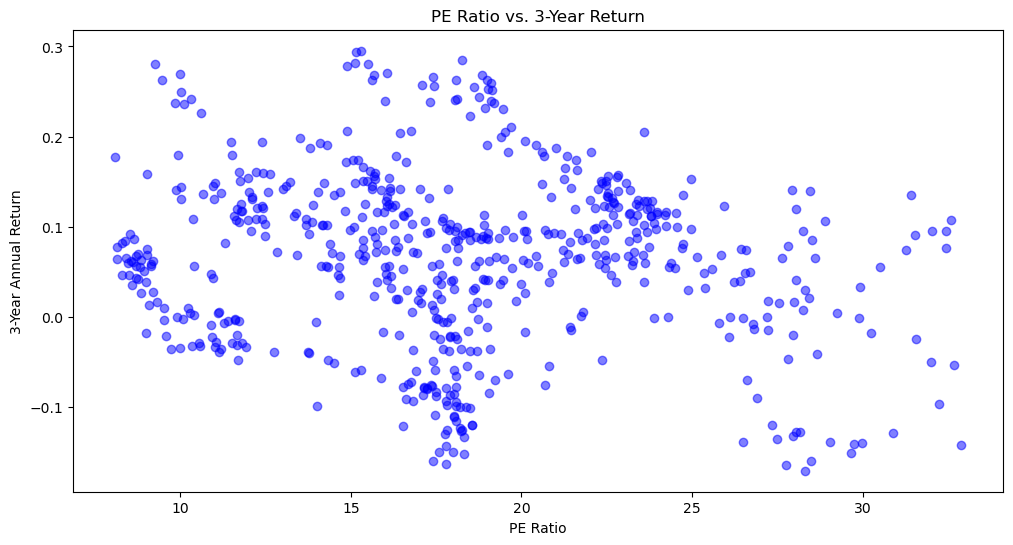

In [11]:
# Convert Date to datetime format
df_filtered['Date'] = pd.to_datetime(df['Date'])

# Set Date as the index for time series data
df_filtered.set_index('Date', inplace=True)

# Plot PE Ratio vs 3-Year Return to visually inspect the relationship
plt.figure(figsize=(12, 6))
plt.scatter(df_filtered['PE Ratio'], df_filtered['3 Year Annual Return'], color='blue', alpha=0.5)
plt.title("PE Ratio vs. 3-Year Return")
plt.xlabel("PE Ratio")
plt.ylabel("3-Year Annual Return")
plt.show()

plt.show()


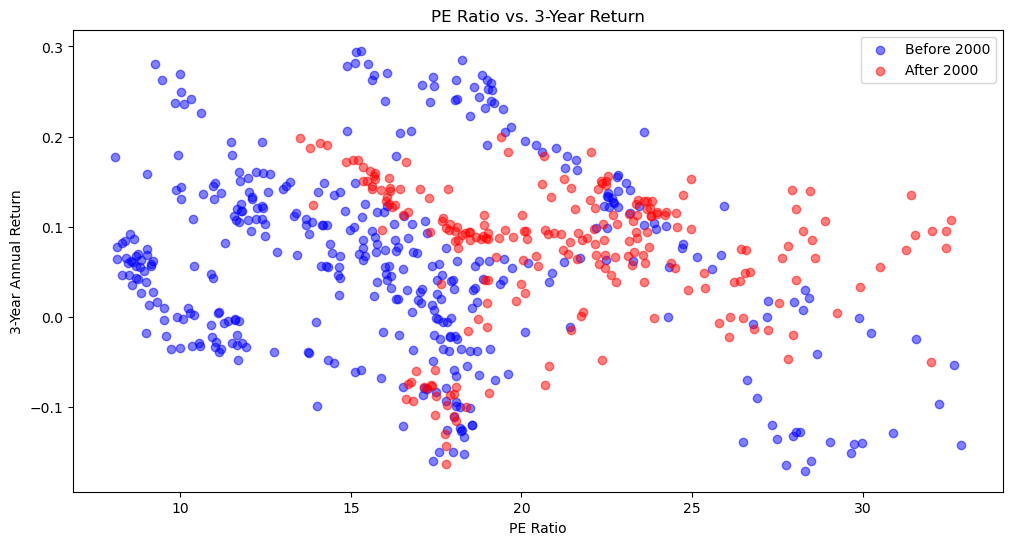

In [12]:
# Create a boolean mask for dates after 2005
after_2000 = df_filtered.index.year > 2000

# Separate data points based on the mask
pe_before_2000 = df_filtered.loc[~after_2000, 'PE Ratio']
return_before_2000 = df_filtered.loc[~after_2000, '3 Year Annual Return']
pe_after_2000 = df_filtered.loc[after_2000, 'PE Ratio']
return_after_2000 = df_filtered.loc[after_2000, '3 Year Annual Return']

# Plot the scatter plot with different colors
plt.figure(figsize=(12, 6))
plt.scatter(pe_before_2000, return_before_2000, color='blue', alpha=0.5, label='Before 2000')
plt.scatter(pe_after_2000, return_after_2000, color='red', alpha=0.5, label='After 2000')

plt.title("PE Ratio vs. 3-Year Return")
plt.xlabel("PE Ratio")
plt.ylabel("3-Year Annual Return")
plt.legend()  # Add a legend to distinguish the colors
plt.show()

/var/folders/gd/8x_7tck95jx01q0_jm10xb1m0000gn/T/ipykernel_97378/3822126771.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['PE Ratio'] = df_filtered['PE Ratio'].astype(float)


AIC     3
BIC     2
HQIC    3
FPE     3
dtype: int64


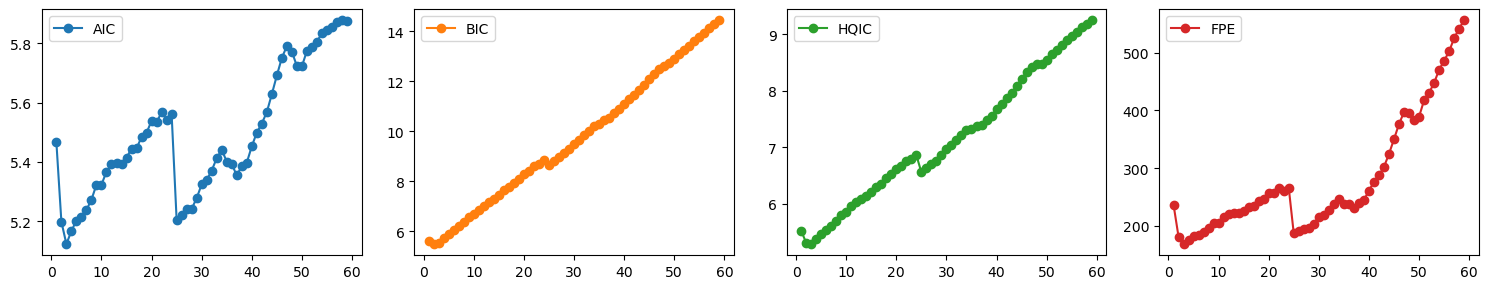

In [13]:
from statsmodels.tsa.api import VAR

#PE ratio as a float variable
df_filtered['PE Ratio'] = df_filtered['PE Ratio'].astype(float)

df['PE Ratio'] = df['PE Ratio'].astype(float)
#Set Date as the index for time series data

df_filtered.index = pd.DatetimeIndex(df_filtered.index).to_period('M')


# test Vector AutoRegression (VAR) Model
def splitter(data_df):
    end = round(len(data_df)*.8)
    train_df = data_df[:end]
    test_df = data_df[end:]
    return train_df, test_df

train_df, test_df = splitter(df_filtered)

def select_p(train_df):
    
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df) 
    p = np.arange(1,60)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))

select_p(train_df.dropna())


Real Total Return Price     0
PE Ratio                    0
5 Year Annual Return       48
3 Year Annual Return       30
dtype: int64


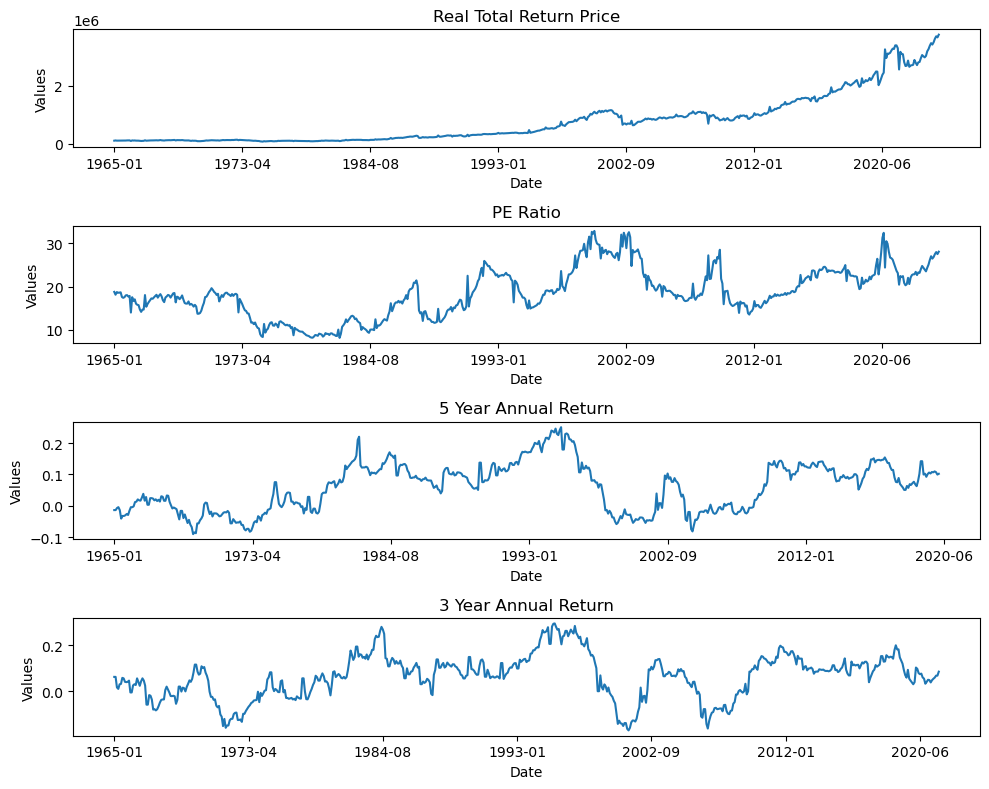

In [14]:
# these are different parameters of multivariate info criteria
# i will look up how to interpret each of these
# BIC and HQIC has the lowest value at 2, FPE and AIC at 3
# BIC = 
# AIC =
# HQIC = 
# FPE = 

# Function to plot time series
def plot_series(data):
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))
    for i, col in enumerate(data.columns):
        data[col].plot(ax=axes[i], title=col)
        axes[i].set_ylabel('Values')
        axes[i].set_xlabel('Date')
    plt.tight_layout()
    plt.show()

p = 2
print(df_filtered.isnull().sum())
model = VAR(df_filtered.dropna())
var_model = model.fit(p)

# Forecasting
lag_order = var_model.k_ar
forecast = var_model.forecast(df_filtered.values[-lag_order:], steps=10)

# Visualizing the Forecast
forecast_index = pd.date_range(start='1965-01', periods=10)
forecast_data = pd.DataFrame(forecast, index=forecast_index, columns=df_filtered.columns)
plot_series(pd.concat([df_filtered, forecast_data]))




In [15]:
from statsmodels.tsa.stattools import grangercausalitytests

df_b = df_filtered.dropna()

# would need to add the 5 year annual return column to compare

grangercausalitytests(df_b[['3 Year Annual Return', 'PE Ratio']], maxlag=[3])
# big takeaay here is that p value is 0.02, which tells us that PE ratio is useful to predicting 3 year annual return
grangercausalitytests(df_b[['PE Ratio','3 Year Annual Return']], maxlag=[3])
# 3 year annual return is NOT predictive of PE ratio


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3786  , p=0.0181  , df_denom=587, df_num=3
ssr based chi2 test:   chi2=10.2567 , p=0.0165  , df=3
likelihood ratio test: chi2=10.1692 , p=0.0172  , df=3
parameter F test:         F=3.3786  , p=0.0181  , df_denom=587, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5746  , p=0.6319  , df_denom=587, df_num=3
ssr based chi2 test:   chi2=1.7444  , p=0.6271  , df=3
likelihood ratio test: chi2=1.7419  , p=0.6277  , df=3
parameter F test:         F=0.5746  , p=0.6319  , df_denom=587, df_num=3


{3: ({'ssr_ftest': (0.5746172638988173, 0.631878930509572, 587.0, 3),
   'ssr_chi2test': (1.7444087977303107, 0.6271062505070804, 3),
   'lrtest': (1.7418523856067623, 0.6276694858306806, 3),
   'params_ftest': (0.574617263898877, 0.6318789305095431, 587.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

/var/folders/gd/8x_7tck95jx01q0_jm10xb1m0000gn/T/ipykernel_97378/2274513882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["3 Year Annual Return"] = df_filtered["3 Year Annual Return"].fillna(df_filtered["3 Year Annual Return"].mean())


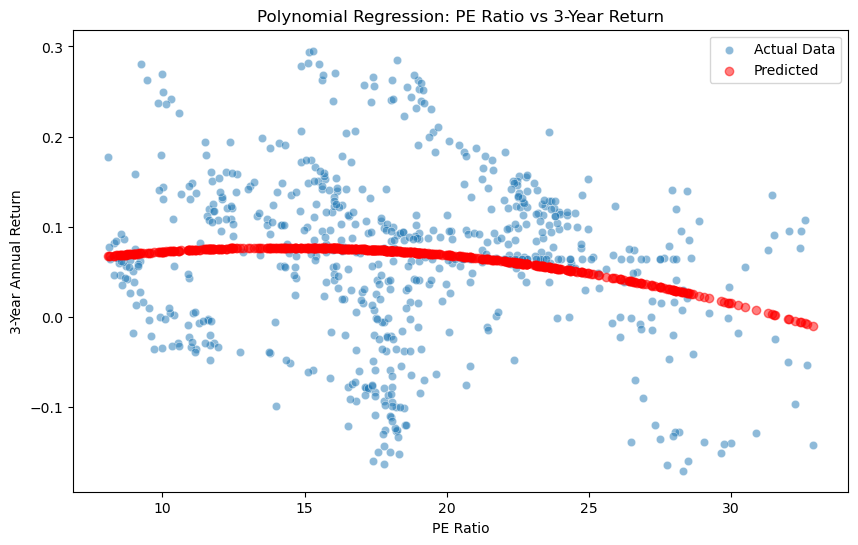

R² Score: 0.0323


In [16]:
df_filtered["3 Year Annual Return"] = df_filtered["3 Year Annual Return"].fillna(df_filtered["3 Year Annual Return"].mean())


# Generate polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(df_filtered[["PE Ratio"]])

# Fit model
model_poly = LinearRegression().fit(X_poly, df_filtered["3 Year Annual Return"])
y_pred = model_poly.predict(X_poly)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_filtered["PE Ratio"], y=df_filtered["3 Year Annual Return"], alpha=0.5, label="Actual Data")
plt.scatter(df_filtered["PE Ratio"], y_pred, color='red', alpha=0.5, label="Predicted")
plt.xlabel("PE Ratio")
plt.ylabel("3-Year Annual Return")
plt.legend()
plt.title("Polynomial Regression: PE Ratio vs 3-Year Return")
plt.show()

print(f"R² Score: {r2_score(df_filtered['3 Year Annual Return'], y_pred):.4f}")

In [ ]:
# Compute correlation matrix
corr_matrix = df_filtered[["PE Ratio", "3 Year Annual Return"]].corr()

# Plot heatmap
plt.figure(figsize=(5, 4))  # Adjust figure size for clarity
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Add title
plt.title("Correlation: PE Ratio vs. 3-Year Return")

# Show plot
plt.show()

In [ ]:
df_filtered = df_filtered.reset_index()
# Filter data for observations after 2000
df_filtered_2000 = df_filtered[df_filtered["Date"] <= "1995-01-01"]

# Compute correlation matrix for PE Ratio and 3-Year Annual Return
corr_matrix = df_filtered_2000[["PE Ratio", "3 Year Annual Return"]].corr()

# Plot heatmap
plt.figure(figsize=(5, 4))  # Adjust figure size for clarity
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Add title
plt.title("Correlation: PE Ratio vs. 3-Year Return (Pre-1995)")

# Show plot
plt.show()



# Filter data for observations after 2000
df_filtered_2000 = df_filtered[df_filtered["Date"] >= "2002-01-01"]

# Compute correlation matrix for PE Ratio and 3-Year Annual Return
corr_matrix = df_filtered_2000[["PE Ratio", "3 Year Annual Return"]].corr()

# Plot heatmap
plt.figure(figsize=(5, 4))  # Adjust figure size for clarity
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Add title
plt.title("Correlation: PE Ratio vs. 3-Year Return (Post-2002)")

# Show plot
plt.show()


In [ ]:

df_filtered["PE Ratio"] = pd.to_numeric(df_filtered["PE Ratio"], errors="coerce")
print(df_filtered.dtypes)

